In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import torchvision

## Brain - Model Alignment 

In [3]:
results_df = pd.read_csv('./results/weights_brain_eval_normalized.csv')
results_df

,model_name,layer_name,forward_lin_pred,forward_best_alpha,backward_lin_pred,backward_best_alpha,RSA_pearson
0,vgg16_kaiming_n_seed0,features.23,0.297647,10000.0,0.544957,1.000000e-08,0.184564
1,vgg16_kaiming_n_seed0,features.30,0.294876,10000.0,0.499204,1.000000e-08,0.173535
2,vgg16_kaiming_n_seed0,classifier.0,0.266523,10000.0,0.491681,1.000000e+03,0.166340
3,vgg16_kaiming_n_seed0,classifier.3,0.120985,100000.0,0.075482,1.000000e+05,0.067987
4,vgg16_kaiming_n_seed1,features.23,0.289400,10000.0,0.520815,1.000000e-08,0.136596
...,...,...,...,...,...,...,...
279,vgg16_xavier_u_seed8,classifier.3,0.097959,100000.0,0.070235,1.000000e+05,0.052319
280,vgg16_xavier_u_seed9,features.23,0.294613,10000.0,0.512788,1.000000e-08,0.156567
281,vgg16_xavier_u_seed9,features.30,0.286301,10000.0,0.466623,1.000000e-08,0.146027
282,vgg16_xavier_u_seed9,classifier.0,0.258170,10000.0,0.479993,1.000000e+03,0.131015


In [4]:
model_names = pd.unique(results_df['model_name'])
model_names = np.unique([mn.split('_seed')[0] for mn in model_names])
layer_names = pd.unique(results_df['layer_name'], )
# collect neural preds across model seeds
model_seed_linpred = {}
model_seed_rsa = {}
# model_seed_linpred[model][layer] = [linpred_seed1, ... linpred_seed10]

for mn in list(model_names):
    mn = str(mn)
    mn_seed_indices = results_df.index[results_df['model_name'].str.startswith(mn)].tolist()
    for mn_seed_ind in mn_seed_indices:
        layer_name = results_df.iloc[mn_seed_ind]['layer_name']
        forward_linpred = results_df.iloc[mn_seed_ind]['forward_lin_pred']
        backward_linpred = results_df.iloc[mn_seed_ind]['backward_lin_pred']
        rsa_score = results_df.iloc[mn_seed_ind]['RSA_pearson']

        # init model_name in dict
        if mn not in list(model_seed_linpred.keys()):
            model_seed_linpred[mn] = {}
            model_seed_rsa[mn] = {}

        # init layer_name in mn sub-dict
        if layer_name not in list(model_seed_linpred[mn].keys()):
            model_seed_linpred[mn][layer_name] = []
            model_seed_rsa[mn][layer_name] = []
            
        model_seed_linpred[mn][layer_name].append([forward_linpred,backward_linpred])
        model_seed_rsa[mn][layer_name].append(float(rsa_score))
                                                
        
    

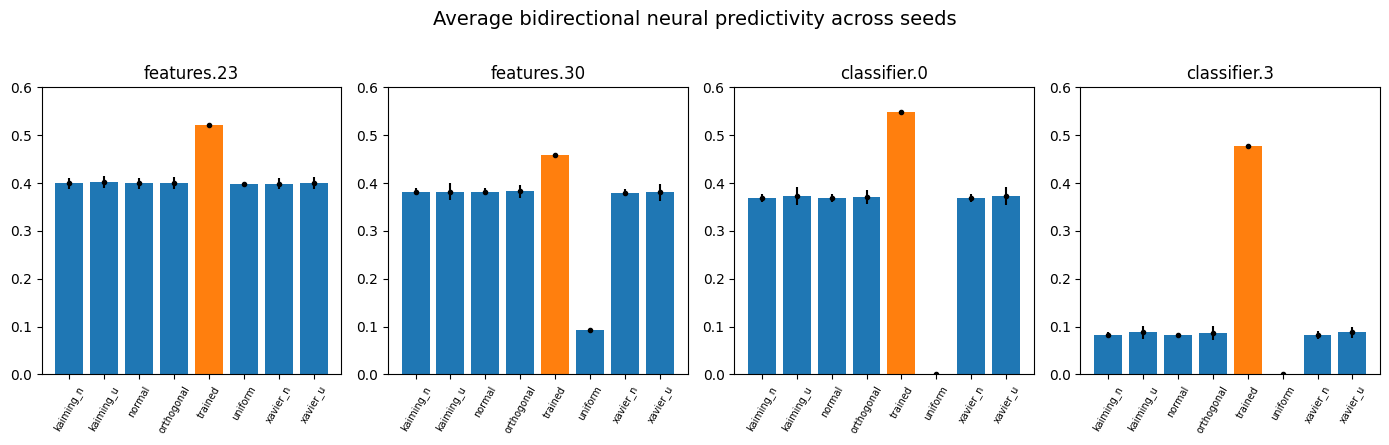

In [5]:
# 1x4 subplot of lin preds across different inits for (4 layers)
plt.figure(figsize=(14,4))

for pi in range(1,5):
    plt.subplot(1,4,pi)
    ln = layer_names[pi-1]
    plt.title(ln)
    plot_x = [mn.split('_', 1)[1] if '_' in mn else mn for mn in model_names]
    plot_y = []
    y_sd = []
    bar_colors = []
    
    for mn in model_names:
        plot_y.append(np.mean(np.mean(model_seed_linpred[mn][ln], axis=1)))
        y_sd.append(np.std(np.mean(model_seed_linpred[mn][ln], axis=1)))
        if "trained" in mn:
            bar_colors.append("tab:orange")
        else:
            bar_colors.append("tab:blue")
    
    plt.bar(plot_x, plot_y, color=bar_colors)
    plt.errorbar(plot_x, plot_y, y_sd, fmt=".", color='k')
    plt.xticks(rotation=60, fontsize=7)
    plt.ylim([0, 0.6])
    


plt.tight_layout()
plt.suptitle("Average bidirectional neural predictivity across seeds", fontsize=14, y=1.1)
plt.show()

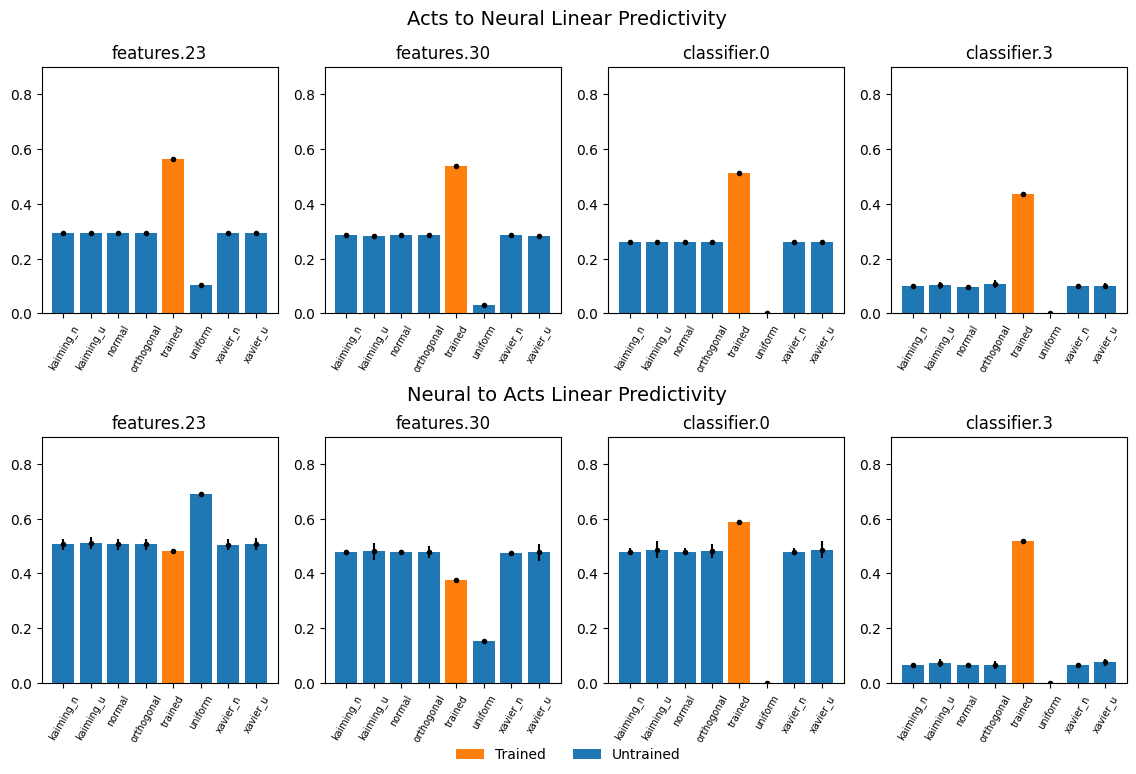

In [6]:
fig = plt.figure(figsize=(14,8))

# ---------- Top row: Acts → Neural ----------
for pi in range(1,5):
    plt.subplot(2,4,pi)
    ln = layer_names[pi-1]
    plt.title(ln)

    plot_x = [mn.split('_', 1)[1] if '_' in mn else mn for mn in model_names]
    plot_y, y_sd, bar_colors = [], [], []

    for mn in model_names:
        plot_y.append(np.mean(model_seed_linpred[mn][ln], axis=0)[0])
        y_sd.append(np.std(model_seed_linpred[mn][ln], axis=0)[0])
        bar_colors.append("tab:orange" if "trained" in mn else "tab:blue")

    plt.bar(plot_x, plot_y, color=bar_colors)
    plt.errorbar(plot_x, plot_y, y_sd, fmt=".", color='k')
    plt.xticks(rotation=60, fontsize=7)
    plt.ylim([0, 0.9])


# ---------- Bottom row: Neural → Acts ----------
for pi in range(1,5):
    plt.subplot(2,4,pi+4)
    ln = layer_names[pi-1]
    plt.title(ln)

    plot_x = [mn.split('_', 1)[1] if '_' in mn else mn for mn in model_names]
    plot_y, y_sd, bar_colors = [], [], []

    for mn in model_names:
        plot_y.append(np.mean(model_seed_linpred[mn][ln], axis=0)[1])
        y_sd.append(np.std(model_seed_linpred[mn][ln], axis=0)[1])
        bar_colors.append("tab:orange" if "trained" in mn else "tab:blue")

    plt.bar(plot_x, plot_y, color=bar_colors)
    plt.errorbar(plot_x, plot_y, y_sd, fmt=".", color='k')
    plt.xticks(rotation=60, fontsize=7)
    plt.ylim([0, 0.9])


# ---------- Titles and layout ----------
fig.text(0.5, 0.94, 'Acts to Neural Linear Predictivity', ha='center', va='center', fontsize=14)
fig.text(0.5, 0.47, 'Neural to Acts Linear Predictivity', ha='center', va='center', fontsize=14)
plt.subplots_adjust(hspace=0.5)

# optional legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='tab:orange', label='Trained'),
    Patch(facecolor='tab:blue', label='Untrained')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, frameon=False)

plt.show()


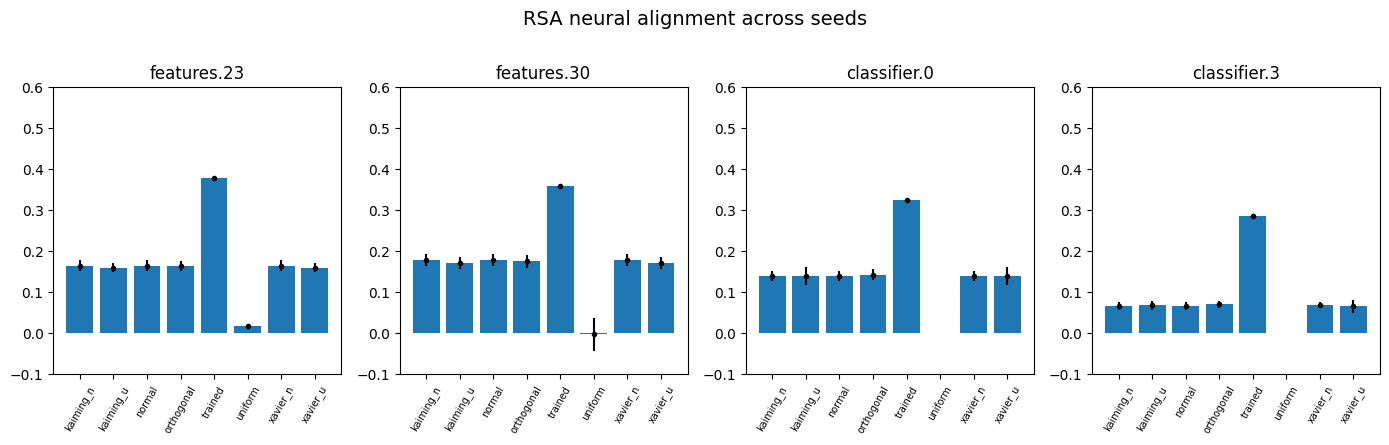

In [7]:
# 2x2 subplot of lin preds across different inits for (4 layers)
plt.figure(figsize=(14,4))

for pi in range(1,5):
    plt.subplot(1,4,pi)
    ln = layer_names[pi-1]
    plt.title(ln)
    plot_x = [mn.split('_', 1)[1] if '_' in mn else mn for mn in model_names]
    
    plot_y = []
    y_sd = []
    for mn in model_names:
        plot_y.append(np.mean(model_seed_rsa[mn][ln]))
        y_sd.append(np.std(model_seed_rsa[mn][ln]))
    
    plt.bar(plot_x, plot_y)
    plt.errorbar(plot_x, plot_y, y_sd, fmt=".", color='k')
    plt.xticks(rotation=60, fontsize=7)
    plt.ylim([-0.1, 0.6])
    


plt.tight_layout()
plt.suptitle("RSA neural alignment across seeds", fontsize=14, y=1.1)
plt.show()

## Predicting Neuron FRs

In [7]:
results_df = pd.read_pickle('./results/weights_neuron_pred_eval_normalized.pkl')
results_df

,model_name,layer_name,neuron_corrs
0,vgg16_kaiming_n_seed0,features.23,"[-0.02110491780372711, 0.42696331271872257, 0...."
1,vgg16_kaiming_n_seed0,features.30,"[-0.047715394656959606, 0.4148716391894053, 0...."
2,vgg16_kaiming_n_seed0,classifier.0,"[-0.007356981935466527, 0.3903228447431609, 0...."
3,vgg16_kaiming_n_seed0,classifier.3,"[-0.0008592662197646494, 0.17907112603332465, ..."
4,vgg16_kaiming_n_seed1,features.23,"[0.03121666331095711, 0.4237541347764958, 0.81..."
...,...,...,...
279,vgg16_xavier_u_seed8,classifier.3,"[-0.013392620782226753, 0.16266222165078942, 0..."
280,vgg16_xavier_u_seed9,features.23,"[-0.021315436116318913, 0.42706027085223425, 0..."
281,vgg16_xavier_u_seed9,features.30,"[-0.026849037796130883, 0.3973788972042339, 0...."
282,vgg16_xavier_u_seed9,classifier.0,"[-0.010078481199444694, 0.38202179905482353, 0..."


In [8]:
model_names = pd.unique(results_df['model_name'])
model_names = np.unique([mn.split('_seed')[0] for mn in model_names])
layer_names = pd.unique(results_df['layer_name'], )
model_names = np.delete(model_names, np.where(model_names == 'vgg16_constant'))
model_names

array(['vgg16_kaiming_n', 'vgg16_kaiming_u', 'vgg16_normal',
       'vgg16_orthogonal', 'vgg16_trained', 'vgg16_uniform',
       'vgg16_xavier_n', 'vgg16_xavier_u'], dtype='<U16')

In [9]:
model_seed_corrs = {}
for mn in list(model_names):
    mn = str(mn)
    mn_seed_indices = results_df.index[results_df['model_name'].str.startswith(mn)].tolist()
    
    for mn_seed_ind in mn_seed_indices:
        layer_name = results_df.iloc[mn_seed_ind]['layer_name']
        neuron_corrs = results_df.iloc[mn_seed_ind]['neuron_corrs']

        # init model_name in dict
        if mn not in list(model_seed_corrs.keys()):
            model_seed_corrs[mn] = {}

        # init layer_name in mn sub-dict
        if layer_name not in list(model_seed_corrs[mn].keys()):
            model_seed_corrs[mn][layer_name] = []
            
        model_seed_corrs[mn][layer_name].append(neuron_corrs)                                                


In [10]:
def partial_correlation(x, y, z):
    """
    Compute the partial correlation between x and y, controlling for z.
    Parameters:
    x : array-like, shape (n_samples,)
        First variable.
    y : array-like, shape (n_samples,)
        Second variable.
    z : array-like, shape (n_samples,)
        Control variable.
    Returns:
    float
        Partial correlation coefficient between x and y controlling for z.
    """
    # Regress x on z and get residuals
    x, y, z = np.array(x), np.array(y), np.array(z)
    reg_x = LinearRegression().fit(z.reshape(-1, 1), x)
    x_residuals = x - reg_x.predict(z.reshape(-1, 1))
    
    # Regress y on z and get residuals
    reg_y = LinearRegression().fit(z.reshape(-1, 1), y)
    y_residuals = y - reg_y.predict(z.reshape(-1, 1))
    
    # Compute Pearson correlation between the residuals
    p_corr, _ = pearsonr(x_residuals, y_residuals)
    
    return p_corr

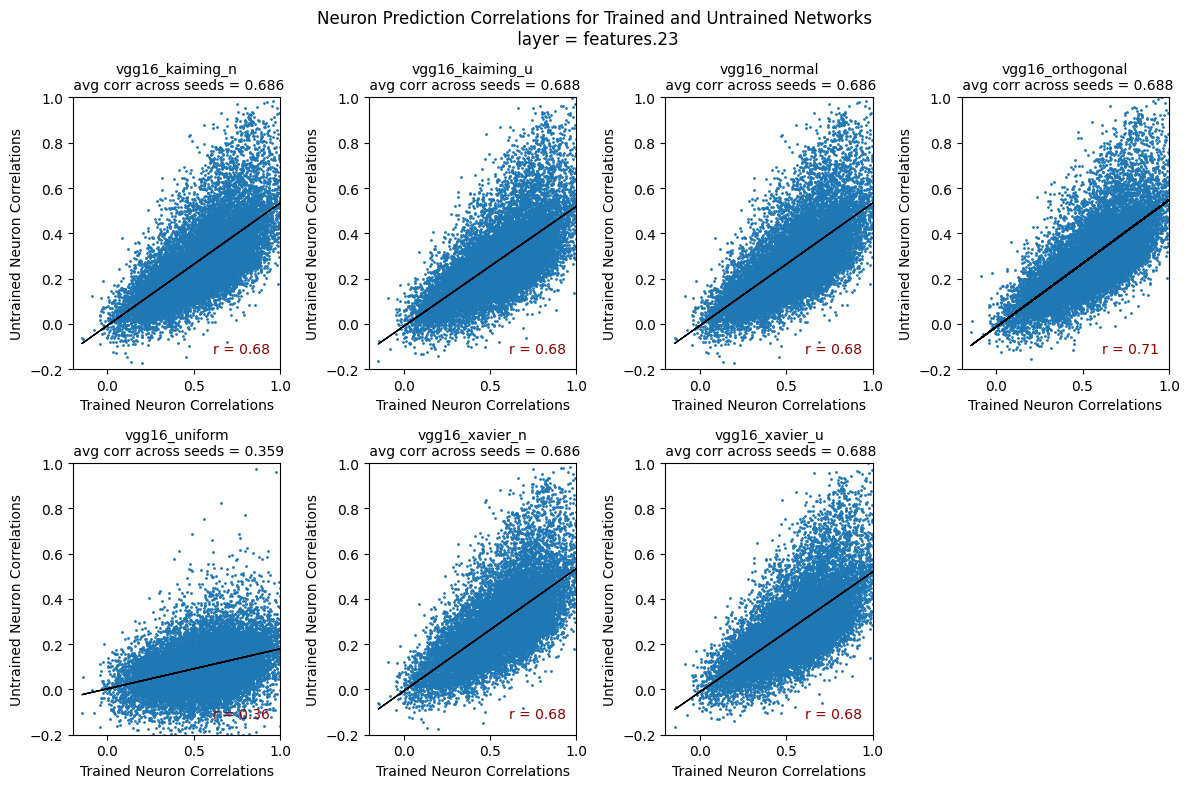

In [11]:
# single plot of each untrained model seed0s correlation with trained model 
num_models = len(model_names)
layer_name = layer_names[0] # VARY 0-3
x_values = model_seed_corrs['vgg16_trained'][layer_name][0]


plt.figure(figsize=(12,8))
plt_index=1
for mi, mn in enumerate(model_names):
    plt.subplot(2,4,plt_index)
    if mn == 'vgg16_trained':
        continue
    y_values = model_seed_corrs[mn][layer_name][0]
    plt.scatter(x_values, y_values, s=1)
    
    # corr line
    r, p = pearsonr(x_values, y_values)
    slope, intercept = np.polyfit(x_values, y_values, 1)
    line = slope * np.array(x_values) + intercept
    plt.plot(x_values, line, color='black', linewidth=1)
    plt.text(0.95, 0.05, f"r = {r:.2f}",
             transform=plt.gca().transAxes,
             ha='right', va='bottom',
             fontsize=10, color='darkred')
    # partial correlation controlling reliability
    # p_corr = partial_correlation(x_values, y_values, neuron_reliability)
    
    seed_avg_corr = np.mean([np.corrcoef(x_values, model_seed_corrs[mn][layer_name][i])[0,1] for i in range(10)])
    plt.xlabel("Trained Neuron Correlations")
    plt.ylabel("Untrained Neuron Correlations")
    plt.title(f'{mn}\n avg corr across seeds = {seed_avg_corr:.3f}', fontsize=10)
    plt.xlim([-0.2, 1])
    plt.ylim([-0.2, 1])
    plt_index +=1


plt.suptitle(f"Neuron Prediction Correlations for Trained and Untrained Networks\n layer = {layer_name}")
plt.tight_layout()
plt.show()


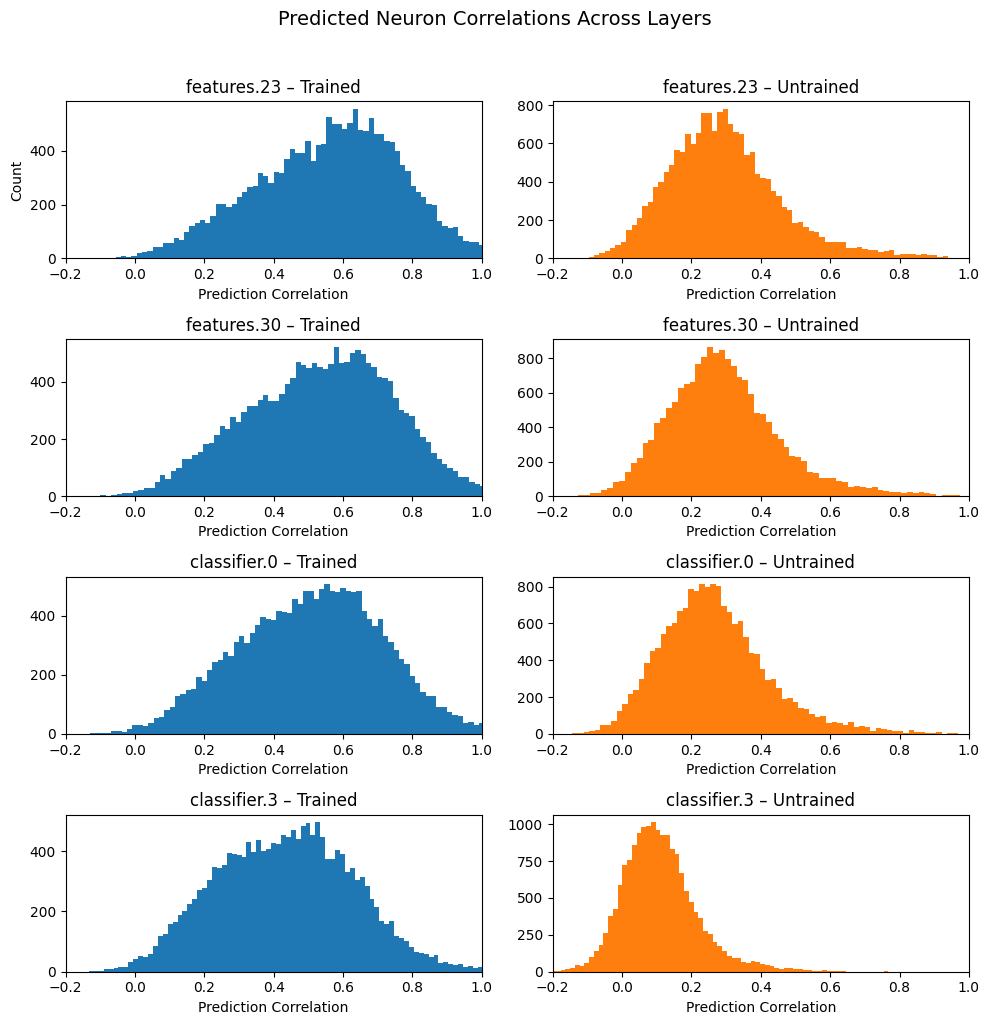

In [12]:
num_layers = 4  # number of layers you want to visualize
layers_to_plot = layer_names[:num_layers]

plt.figure(figsize=(10, 2.5 * num_layers))

for i, layer_name in enumerate(layers_to_plot):
    trained_neuron_corrs = model_seed_corrs['vgg16_trained'][layer_name][0]
    untrained_neuron_corrs = model_seed_corrs['vgg16_kaiming_n'][layer_name][0]
    
    # Left: trained
    plt.subplot(num_layers, 2, 2 * i + 1)
    plt.hist(trained_neuron_corrs, bins=100)
    plt.title(f"{layer_name} – Trained")
    plt.xlim([-0.2, 1])
    plt.xlabel("Prediction Correlation")
    if i == 0:
        plt.ylabel("Count")

    # Right: untrained
    plt.subplot(num_layers, 2, 2 * i + 2)
    plt.hist(untrained_neuron_corrs, bins=100, color="tab:orange")
    plt.title(f"{layer_name} – Untrained")
    plt.xlim([-0.2, 1])
    plt.xlabel("Prediction Correlation")

plt.suptitle("Predicted Neuron Correlations Across Layers", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

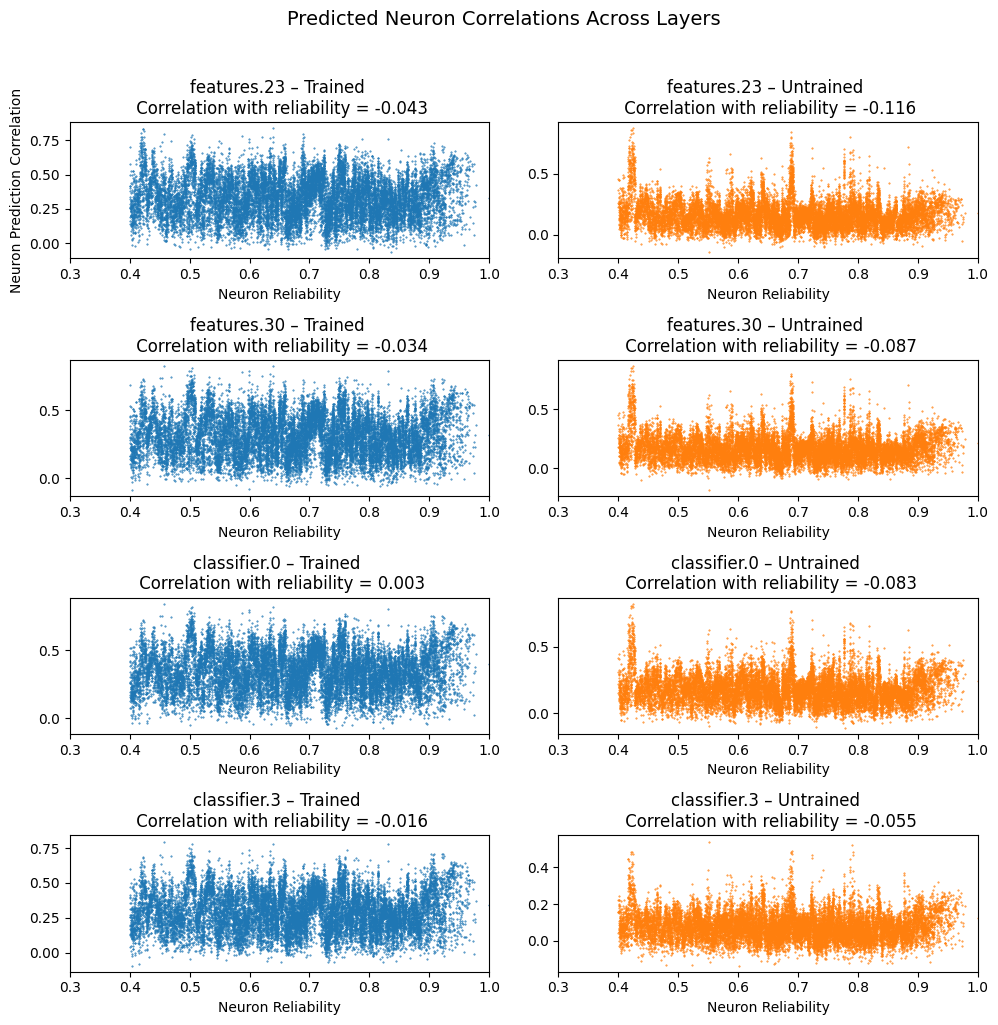

In [ ]:
num_layers = 4  # number of layers you want to visualize
layers_to_plot = layer_names[:num_layers]

plt.figure(figsize=(10, 2.5 * num_layers))

for i, layer_name in enumerate(layers_to_plot):
    trained_neuron_corrs = model_seed_corrs['vgg16_trained'][layer_name][0]
    untrained_neuron_corrs = model_seed_corrs['vgg16_kaiming_n'][layer_name][0]
    trained_corr_with_reliability = pearsonr(trained_neuron_corrs, neuron_reliability)[0]
    untrained_corr_with_reliability = pearsonr(untrained_neuron_corrs, neuron_reliability)[0]
    
    # Left: trained
    plt.subplot(num_layers, 2, 2 * i + 1)
    plt.scatter(neuron_reliability, trained_neuron_corrs, s=0.2)
    plt.title(f"{layer_name} – Trained \n Correlation with reliability = {trained_corr_with_reliability:.3f}")
    plt.xlim([0.3, 1])
    plt.xlabel("Neuron Reliability")
    if i == 0:
        plt.ylabel("Neuron Prediction Correlation")

    # Right: untrained
    plt.subplot(num_layers, 2, 2 * i + 2)
    plt.scatter(neuron_reliability, untrained_neuron_corrs, s=0.2, color='tab:orange')
    plt.title(f"{layer_name} – Untrained \n Correlation with reliability = {untrained_corr_with_reliability:.3f}")
    plt.xlim([0.3, 1])
    plt.xlabel("Neuron Reliability")

    
plt.suptitle("Predicted Neuron Correlations Across Layers", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Layerwise evolution

In [14]:
results_df = pd.read_csv('./results/weights_brain_eval_normalized_all_layers_normalized.csv')

In [15]:
model_names = pd.unique(results_df['model_name'])
model_names = np.unique([mn.split('_seed')[0] for mn in model_names])
layer_names = pd.unique(results_df['layer_name'], )
# collect neural preds across model seeds
model_seed_linpred = {}
model_seed_rsa = {}
# model_seed_linpred[model][layer] = [linpred_seed1, ... linpred_seed10]

for mn in list(model_names):
    mn = str(mn)
    mn_seed_indices = results_df.index[results_df['model_name'].str.startswith(mn)].tolist()
    for mn_seed_ind in mn_seed_indices:
        layer_name = results_df.iloc[mn_seed_ind]['layer_name']
        forward_linpred = results_df.iloc[mn_seed_ind]['forward_lin_pred']
        backward_linpred = results_df.iloc[mn_seed_ind]['backward_lin_pred']
        rsa_score = results_df.iloc[mn_seed_ind]['RSA_pearson']

        # init model_name in dict
        if mn not in list(model_seed_linpred.keys()):
            model_seed_linpred[mn] = {}
            model_seed_rsa[mn] = {}

        # init layer_name in mn sub-dict
        if layer_name not in list(model_seed_linpred[mn].keys()):
            model_seed_linpred[mn][layer_name] = []
            model_seed_rsa[mn][layer_name] = []
            
        model_seed_linpred[mn][layer_name].append([forward_linpred,backward_linpred])
        model_seed_rsa[mn][layer_name].append(rsa_score)


In [19]:
model = torchvision.models.vgg16()
pretty_layer_names = []
named_modules = dict(model.named_modules())
counters = {}
for layer in layer_names:
    if layer == 'input_layer':
        pretty_layer_names.append('Input')
        continue
    
    # Drop leading "model." if present
    module = named_modules.get(layer.replace('model.', ''), None)
    if module is None:
        pretty_layer_names.append(layer)
        continue
    
    layer_type = module.__class__.__name__
    counters[layer_type] = counters.get(layer_type, 0) + 1
    pretty_layer_names.append(f"{layer_type.replace('2d','')}{counters[layer_type]}")

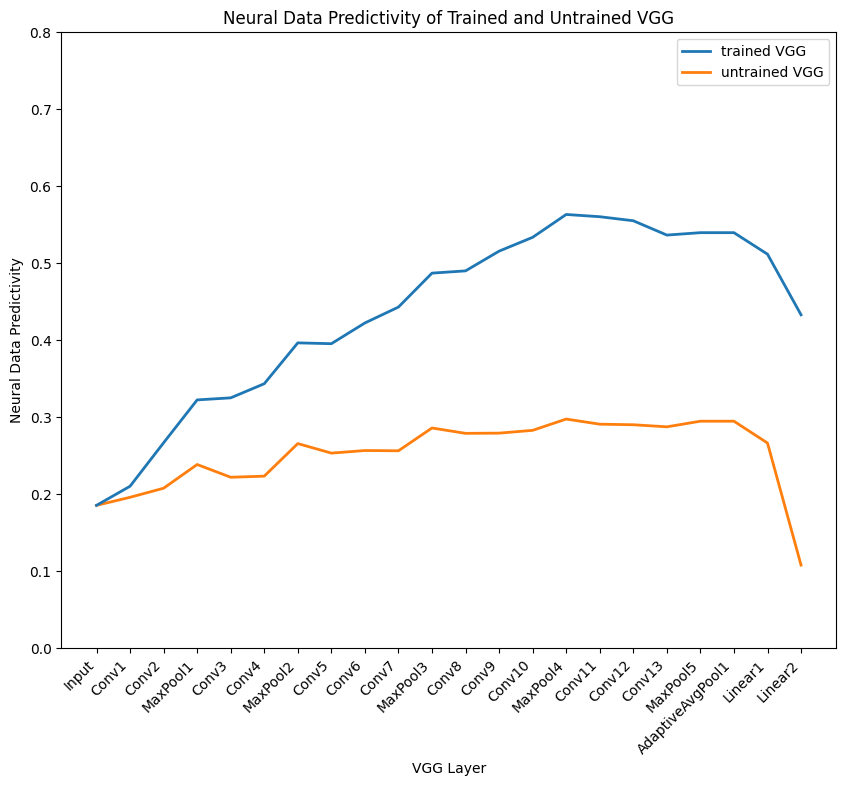

In [21]:
plt.figure(figsize=(10,8))

for mn in model_names:
    layerwise_corrs=[]
    for ln in layer_names:
        layerwise_corrs.append(float(model_seed_linpred[mn][ln][0][0]))

    if mn.endswith("_trained"):
        lab = "trained VGG"
        color = "tab:blue"
    else:
        lab = "untrained VGG"
        color = "tab:orange"
        
    plt.plot(pretty_layer_names,layerwise_corrs, label=lab, color=color, linewidth=2)
    

plt.ylim([0, 0.8])
plt.ylabel("Neural Data Predictivity")
plt.xlabel("VGG Layer")
plt.xticks(rotation=45, ha='right')
plt.title("Neural Data Predictivity of Trained and Untrained VGG")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.show()

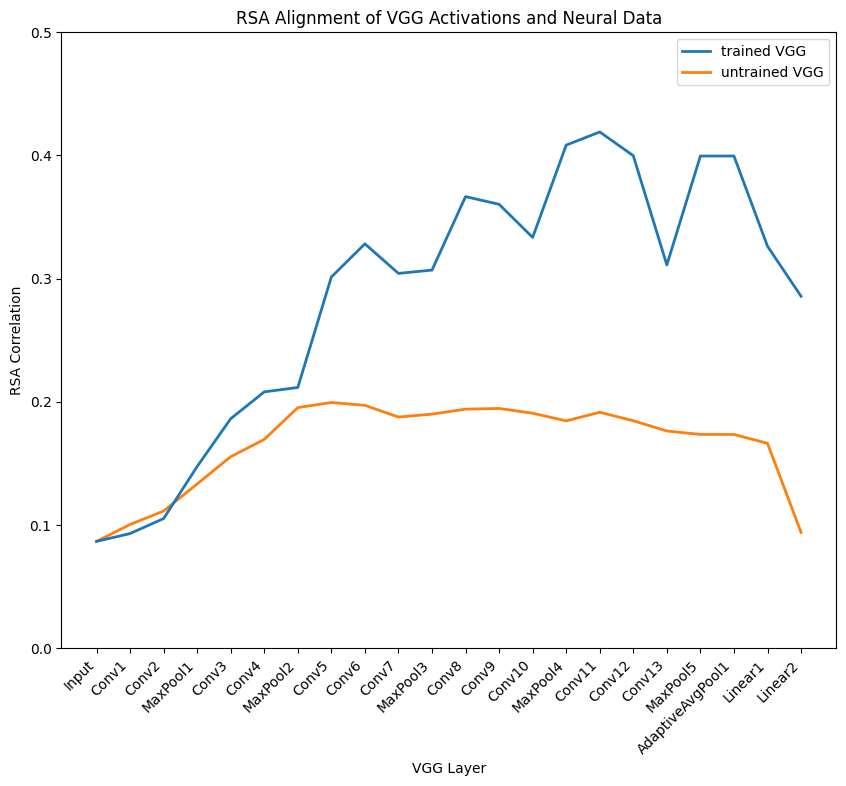

In [85]:
plt.figure(figsize=(10,8))

for mn in model_names:
    layerwise_corrs=[]
    for ln in layer_names:
        if ln in ["classifier.6", "classifier.3", "nan"]:
            print(ln)
            continue
        layerwise_corrs.append(float(model_seed_rsa[mn][ln][0]))

    if mn.endswith("_trained"):
        lab = "trained VGG"
        color = "tab:blue"
    else:
        lab = "untrained VGG"
        color = "tab:orange"
        
    plt.plot(pretty_layer_names,layerwise_corrs, label=lab, color=color, linewidth=2)
    

plt.ylim([0, 0.5])
plt.ylabel("RSA Correlation")
plt.xlabel("VGG Layer")
plt.xticks(rotation=45, ha='right')
plt.title("RSA Alignment of VGG Activations and Neural Data")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.show()